# Install Packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install keras-tcn

     |████████████████████████████████| 679 kB 32.8 MB/s 


In [46]:
# Let`s import all packages that we may need:

import sys 
import time
import itertools
import datetime
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from itertools import product                    # some useful functions
#from tqdm import tqdm_notebook
from tqdm import tqdm

## for Deep-learing:
from tensorflow import keras
import tensorflow as tf
from keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
#from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout, Flatten, TimeDistributed
from tcn import TCN, tcn_full_summary, compiled_tcn, tcn
from tensorflow.keras.models import Sequential

from google.colab import files#

from keras import Input, Model
from keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D,  Dense, concatenate, Multiply
from keras.activations import relu


# Load Datasets


In [4]:
calender= pd.read_csv('/content/drive/MyDrive/Data/calendar.csv')
calender.head(3)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0


In [5]:
sales = pd.read_csv('/content/drive/MyDrive/Data/sales_train_evaluation.csv')
sales.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,3,0,1,1,1,3,0,1,1,0,0,0,2,0,3,5,0,0,1,1,0,2,1,2,2,1,0,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,2,2,1,2,1,1,1,0,1,1,1,0,0,1,1,0,2,1,0,0,0,0,2,1,3,0,0,1,0,1,0,2,0,0,0,2,3,0,1


In [6]:
sales_dept = sales.groupby('dept_id').sum()
sales_dept.head()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,...,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
dept_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
FOODS_1,2343,2216,1657,1508,1209,1897,1903,2235,1925,1586,1785,1737,2048,2349,2948,3688,2193,1552,1617,1502,1866,2391,2164,1784,1480,1587,1542,1744,2432,2019,1464,1691,1588,1626,1759,2193,2301,1540,1456,1482,...,2591,2583,3192,3523,3062,2461,2544,2657,2639,3169,3712,3185,2841,2860,2799,3184,3800,4415,4285,3506,4020,3602,3759,3925,4951,3895,3417,3306,3262,3252,4130,4257,4225,3264,3119,3073,3251,3735,4195,4031
FOODS_2,4094,4209,3174,3606,2869,4375,3349,4384,4273,3684,3255,3696,3592,3743,4722,4889,3021,3899,3219,2790,3030,3821,3853,3184,2598,2548,2463,2648,3499,3881,3028,3344,3245,3472,3310,4432,5162,3709,3480,3460,...,5124,5518,5661,5792,6588,5247,4942,4734,4446,4974,5524,6473,4957,4662,4111,4089,4973,5781,7129,6384,6296,5410,5906,5897,6997,6188,7531,5873,6537,5982,5842,7563,9069,6226,5311,4648,4551,4815,5940,6535
FOODS_3,16741,16333,12343,13764,10525,15821,15238,21132,18664,13631,11923,12222,11700,12946,17517,18079,10801,11974,10515,9998,11698,14726,14011,11405,9965,9797,9728,11088,13974,14760,10574,11533,11385,12144,12443,16447,17446,12339,11344,11097,...,16173,17355,19829,22692,24847,18443,17462,16241,16232,18561,22691,22996,18155,15997,15962,15642,18895,22527,23955,19252,19278,18187,18528,20585,24804,21752,21958,18152,19504,18908,20135,24756,28153,19668,17718,17069,16935,19586,23464,25401
HOBBIES_1,3610,3172,2497,2531,1714,3133,2855,3831,2741,2514,2412,2355,2524,2698,3567,3221,2106,2389,2031,1915,2131,3985,2809,2532,2344,2619,2424,2505,3918,1917,1595,1666,1507,1738,1480,1881,3579,2512,2363,2787,...,3182,3366,3367,4220,4325,3038,3420,3141,3014,3678,4397,4226,3389,3217,3236,3253,3649,4627,4322,3595,3907,3190,3195,3412,4448,3606,3514,3172,3384,3256,3422,4414,4464,3109,3142,3291,3027,3761,4832,4720
HOBBIES_2,154,185,185,138,100,87,89,155,158,101,135,102,176,124,132,196,127,165,139,134,153,157,169,203,115,139,135,170,170,201,176,167,168,117,173,215,216,175,156,168,...,375,420,419,414,495,285,367,331,339,407,390,457,393,428,494,489,436,587,536,464,466,518,607,467,555,456,381,416,433,450,449,479,552,419,487,449,448,382,501,560


In [7]:
sales_item = sales.groupby('item_id').sum()
sales_item.head(3)

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,...,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
item_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001,6,6,4,6,7,18,10,4,11,10,6,5,12,15,16,18,11,10,12,7,17,9,9,8,5,14,26,8,12,13,5,11,10,14,11,8,22,14,6,9,...,6,3,4,4,30,7,5,3,6,2,16,6,4,5,7,1,9,3,9,1,10,3,1,6,10,6,2,5,6,2,7,8,8,4,7,7,5,7,5,9
FOODS_1_002,4,5,7,4,3,4,1,7,2,4,4,3,1,5,8,5,1,3,2,0,4,5,4,2,2,4,3,5,7,3,3,4,7,7,3,4,11,0,1,1,...,5,4,5,9,4,1,3,5,5,3,3,1,9,4,3,4,5,7,2,5,6,3,2,4,5,3,1,6,3,10,5,8,7,2,6,5,0,6,6,4
FOODS_1_003,14,8,3,6,3,8,13,10,11,6,11,10,3,17,20,14,10,9,3,14,7,23,16,7,12,6,5,7,10,6,10,6,8,3,9,18,18,11,8,4,...,4,1,7,3,5,6,3,4,4,3,11,5,7,13,9,1,2,4,7,9,2,3,13,5,9,5,0,6,3,10,7,8,6,11,9,7,7,10,6,5


In [8]:
sales_item.shape

(3049, 1941)

In [9]:
sales_cat = sales.groupby('cat_id').sum().T
sales_cat.head(3)

cat_id,FOODS,HOBBIES,HOUSEHOLD
d_1,23178,3764,5689
d_2,22758,3357,5634
d_3,17174,2682,3927


In [10]:
sales_cat.index

Index(['d_1', 'd_2', 'd_3', 'd_4', 'd_5', 'd_6', 'd_7', 'd_8', 'd_9', 'd_10',
       ...
       'd_1932', 'd_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937', 'd_1938',
       'd_1939', 'd_1940', 'd_1941'],
      dtype='object', length=1941)

In [11]:
sales_state = sales.groupby('state_id').sum().T
sales_state.head()

state_id,CA,TX,WI
d_1,14195,9438,8998
d_2,13805,9630,8314
d_3,10108,6778,6897
d_4,11047,7381,6984
d_5,9925,5912,3309


In [12]:
sales_cat['days'] = sales_cat.index
sales_state['days'] = sales_state.index

In [13]:
calender = calender.loc[:,['date','d']]
calender.head()

,date,d
0,2011-01-29,d_1
1,2011-01-30,d_2
2,2011-01-31,d_3
3,2011-02-01,d_4
4,2011-02-02,d_5


In [14]:
calender.tail()

,date,d
1964,2016-06-15,d_1965
1965,2016-06-16,d_1966
1966,2016-06-17,d_1967
1967,2016-06-18,d_1968
1968,2016-06-19,d_1969


In [15]:

sales_cat = pd.merge(calender,sales_cat,how = 'inner', left_on = 'd', right_on = 'days')

sales_cat['date'] = pd.to_datetime(sales_cat['date'])

sales_cat = sales_cat.set_index('date')

sales_state = pd.merge(calender,sales_state,how = 'inner', left_on = 'd', right_on = 'days')

sales_state['date'] = pd.to_datetime(sales_state['date'])

sales_state = sales_state.set_index('date')

In [16]:
sales_cat.drop(columns=['days'], inplace=True)
sales_state.drop(columns=['days'], inplace=True)

In [17]:
sales_cat.head()

,d,FOODS,HOBBIES,HOUSEHOLD
date,,,,
2011-01-29,d_1,23178,3764,5689
2011-01-30,d_2,22758,3357,5634
2011-01-31,d_3,17174,2682,3927
2011-02-01,d_4,18878,2669,3865
2011-02-02,d_5,14603,1814,2729


In [18]:
sales_state.head()

,d,CA,TX,WI
date,,,,
2011-01-29,d_1,14195,9438,8998
2011-01-30,d_2,13805,9630,8314
2011-01-31,d_3,10108,6778,6897
2011-02-01,d_4,11047,7381,6984
2011-02-02,d_5,9925,5912,3309


In [19]:
sales_overall = pd.DataFrame(sales_cat.sum(axis = 1), columns=['total_sales'])
sales_overall.head()

,total_sales
date,
2011-01-29,32631
2011-01-30,31749
2011-01-31,23783
2011-02-01,25412
2011-02-02,19146


In [20]:
# Remove observations with  lt 20 Sales...To exclude Christmas day from modeling
sales_overall.drop(sales_overall[sales_overall.total_sales <= 20].index, inplace=True)
sales_overall.shape
dat = sales_overall


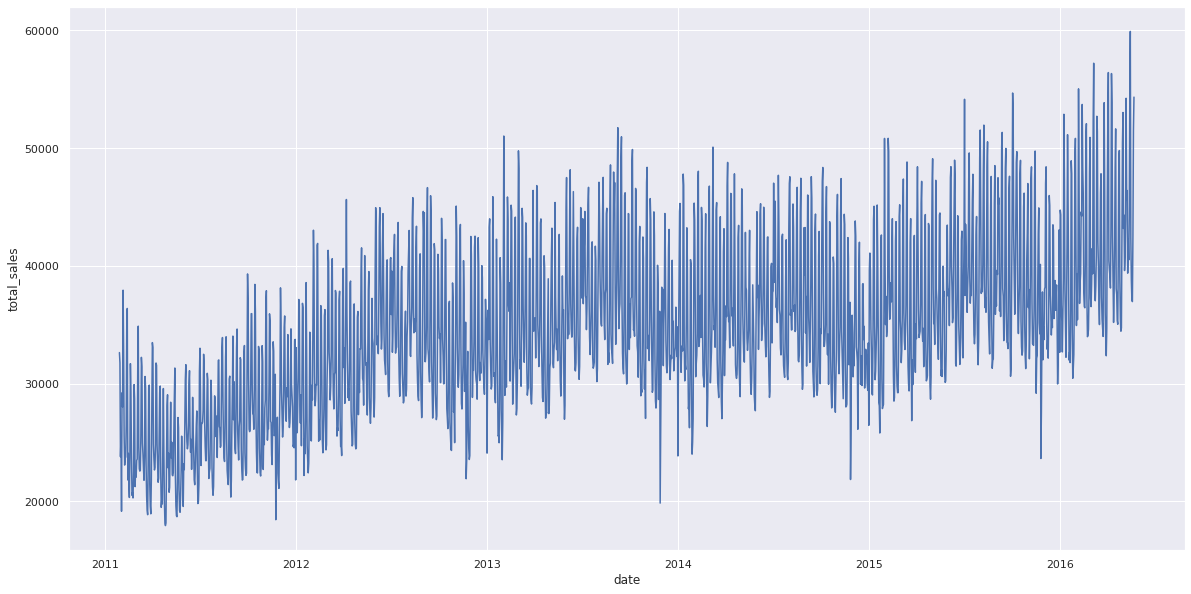

In [21]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=dat, y = 'total_sales', x= sales_overall.index)

In [22]:
dat.shape

(1936, 1)

# Function Definitions

## General Function Definitions


In [23]:
def scale_data(dat, range =(0,1)):
  ## * Note: I scale all features in range of [0,1].

  ## If you would like to train based on the resampled data (over hour), then used below
  values = dat.values
  # normalize features
  scaler = MinMaxScaler(feature_range=range)
  scaled = scaler.fit_transform(values)

  #print(type(scaled))
  print("Shape of scaled dataset-",scaled.shape)
  #print(pd.DataFrame(scaled))

  return scaler, scaled

def forecast(model, historical_dat):
  dat = historical_dat[-1::]
  #print(dat)
  #print(dat.shape)
  yhat = model.predict(dat)
  return yhat[0]

def plot_actual_vs_pred(plot_dat, dat):
  ## time steps, every step is one day (you can easily convert the time step to the actual time index)
  ## 

  fig, ax = plt.subplots(figsize = (12,10))
  actual = plot_dat['test_actual'].reshape(plot_dat['test_actual'].shape[0]*plot_dat['test_actual'].shape[1])
  predicted = plot_dat['test_pred'].reshape(plot_dat['test_pred'].shape[0]*plot_dat['test_pred'].shape[1])
  aa=[x for x in range(len(dat))]
  plt.plot(aa, actual, marker='.', label="actual")
  plt.plot(aa, predicted, 'r', label="prediction")
  plt.ylabel('Sales', size=15)
  plt.xlabel('Time step', size=15)
  plt.legend(fontsize=15)
  plt.show()


def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
def avg(nums):
    nums = list(nums)
    return round(sum(nums) / len(nums), 4)

def repeat_model(model, train, test, epochs, verbose, window=1, n_in=7, batchsize = None):
  start_time = time.time()
  model_dict = dict()
  train_X, train_y = train
  model_history = model.fit(train_X, train_y, epochs=epochs, batch_size=batchsize, validation_data=test, verbose=verbose, shuffle=False)
  history = train[0]
  predicted_vals = list()
  row_shape = [1]
  for i in range(1,len(train[0].shape)):
    row_shape.append(train[0].shape[i])
  row_shape = tuple(row_shape)
  for i in range(0, len(test[0]), window):
    history = np.append(history, test[0][i,:,:].reshape(row_shape), axis=0)
    yhat = forecast(model, history)
    predicted_vals.append(yhat)
  yhat = np.array(predicted_vals).reshape(len(predicted_vals),window)
  test_X = test[0][::window].copy()
  test_y = test[1][::window].copy()
  test_X = test_X.reshape((test_X.shape[0], n_in))
  inv_yhat = np.concatenate((test_X[:, :], yhat), axis=1)
  inv_yhat = scaler.inverse_transform(inv_yhat)
  inv_yhat = inv_yhat[:,-window:]
  test_y = test_y.reshape((len(test_y), window))
  inv_y = np.concatenate((test_X[:, :], test_y), axis=1)
  inv_y = scaler.inverse_transform(inv_y)
  inv_y = inv_y[:,-window:]
  rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
  print('Test RMSE: %.3f' % rmse)
  loss = tf.keras.losses.mean_absolute_percentage_error(inv_y, inv_yhat)
  mae = tf.keras.losses.mean_absolute_error(inv_y, inv_yhat)
  model_dict['test_actual'] = inv_y
  model_dict['test_pred'] = inv_yhat
  model_dict['test_mape'] = np.mean(loss)
  model_dict['test_rmse'] = rmse
  model_dict['test_mae'] = np.mean(mae)
  model_dict['loss_from_model'] = model_history.history['loss'][-1]
  model_dict['val_loss_from_model'] = model_history.history['val_loss'][-1]
  print('MAPE: %.3f' % np.mean(loss))
  elapsed = time.time() - start_time
  model_dict['time_taken'] = elapsed
  return model_dict


def run_model(train, test, n_repeats, epochs, verbose=1, window=1, n_in = 7, learning_rate=0.01, loss= 'mae', batchsize=None, model_type="lstm", l2_regularizer=True):
  models = ["LSTM","CNN","CNN-LSTM","TCN","MACNN"]
  if model_type.upper() == "LSTM":
    model = build_model_lstm(train, window=window, learning_rate=learning_rate, loss = loss)
  elif model_type.upper() == "CNN":
    model = build_model_cnn(train, window=window, learning_rate=learning_rate, loss = loss)
  elif model_type.upper() == "CNN-LSTM":
    model = build_model_cnn_lstm(train, window=window, learning_rate=learning_rate, loss = loss)
  elif model_type.upper() == "TCN":
    model = build_model_tcn(train, window=window, learning_rate=learning_rate, loss = loss)
  elif model_type.upper() == "MACNN":
    if l2_regularizer:
      model = build_model_macnn(train, window=window, learning_rate=learning_rate, loss=loss)
    else:
      model = build_model_macnn_woregl(train, window=window, learning_rate=learning_rate, loss=loss)
  else:
    print("Please select a valid option for Model type")
    print("Available architectures available are-")
    print(models)
    return 0

  iter_history = dict()
  for i in range(n_repeats):
    print("Iteration-%d"%(i+1))
    iter_history['Iteration-'+str(i+1)] = repeat_model(model, train, test, epochs, verbose=verbose, window=window, n_in=n_in)
    print("Model-Loss = %.6f"%(iter_history['Iteration-'+str(i+1)]["loss_from_model"]))
    print("Model-Validation-Loss = %.6f"%(iter_history['Iteration-'+str(i+1)]["val_loss_from_model"]))

  
  print("Average MAPE for test data over %d repetitions is %.4f"%(n_repeats, avg(x["test_mape"] for x in iter_history.values())))
  print("Average MAE for test data over %d repetitions is %.4f"%(n_repeats, avg(x["test_mae"] for x in iter_history.values())))
  print("Average RMSE for test data over %d repetitions is %.4f"%(n_repeats, avg(x["test_rmse"] for x in iter_history.values())))
  plot_actual_vs_pred(iter_history["Iteration-"+str(n_repeats)], test[0])
  iter_history["architecture"] = model_type.upper()
  iter_history["epochs"] = epochs
  iter_history["repeats"] = n_repeats
  iter_history["learning_rate"] = learning_rate
  iter_history["prediction_window"] = window
  iter_history["loss"] = loss.upper()
  #print(iter_history)
  return iter_history



## DL Model Definitions

In [24]:
def build_model_lstm(train_dat, learning_rate, loss, window=1):
  print("Compiling LSTM Model Architecture")
  model = Sequential()
  model.add(LSTM(100, input_shape=(train_dat[0].shape[1], train_dat[0].shape[2])))
  #model.add(LSTM(16))
  model.add(Dropout(0.2))
  #model.add(LSTM(70))
  #model.add(Dropout(0.3))
  model.add(Dense(window))
  model.compile(loss=loss, optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
  return model

In [25]:
def build_model_cnn(train_dat, learning_rate, loss, window=1):
  print("Compiling CNN Model Architecture")
  model = Sequential()
  model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(50, activation='relu'))
  model.add(Dense(window))
  model.compile(loss=loss, optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
  return model
  


In [26]:
def build_model_cnn_lstm(train_dat, learning_rate, loss, window=1):
  print("Compiling CNN-LSTM Model Architecture")
  model = Sequential()
  model.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
  model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(100, activation='relu'))
  model.add(Dense(window))
  model.compile(loss=loss, optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
  #model.summary()
  return model



In [27]:
def build_model_tcn(train_dat, learning_rate, loss, window=1):
  print("Compiling TCN Model Architecture")
  # if time_steps > tcn_layer.receptive_field, then we should not
# be able to solve this task.

  tcn_layer = TCN(input_shape=(train_dat[0].shape[1], 1),
                  nb_filters = 128,
                  dilations = (1,2,4),
                  activation = 'relu',
                  use_skip_connections = True)

  # The receptive field tells you how far the model can see in terms of timesteps.
  print('Receptive field size =', tcn_layer.receptive_field)

  model = Sequential([
      tcn_layer,
      Dense(window)
  ])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss=loss)
  model.summary()
  return model



In [48]:
def build_model_macnn_woregl(train_dat, learning_rate, loss, window=1):
  print("Compiling MACNN model Architecture(without regularization)")
  inputs = Input(shape=(train_dat[0].shape[1],1), name='series')
  conv1_a = Conv1D(filters=64,kernel_size=2, activation='relu',padding='same')(inputs)
  conv1_b = Conv1D(filters=64,kernel_size=7,activation='relu',padding='same')(inputs)
  conv1_c = Conv1D(filters=64,kernel_size=14,activation='relu',padding='same')(inputs)
  conv1 = concatenate([conv1_a, conv1_b, conv1_c])
  conv2 = Conv1D(filters=192,kernel_size=21,activation='relu', padding='same')(inputs)

  #conv1 = BatchNormalization()(conv1)
  msblock = relu(conv1)
  out = GlobalAveragePooling1D()(conv1)

  # Flatten the ouput
  #out = Flatten()(out)
  out = Dense(units=64)(out)
  out = Dense(units=192)(out)
  out = relu(out)

  attblock = Multiply()([out, msblock, conv2])
  attblock = Flatten()(attblock)
  attblock = Dense(units=window)(attblock)

  model = Model(inputs, attblock, name='MACNN')
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0002), loss=loss)
  model.summary()
  return model



In [49]:
def build_model_macnn(train_dat, learning_rate, loss, window=1):
  print("Compiling MACNN model Architecture(with regularization)")
  inputs = Input(shape=(train_dat[0].shape[1],1), name='series')
  conv1_a = Conv1D(filters=64,kernel_size=2, activation='relu',padding='same', kernel_regularizer=keras.regularizers.l2(l2=0.01))(inputs)
  conv1_b = Conv1D(filters=64,kernel_size=7,activation='relu',padding='same', kernel_regularizer=keras.regularizers.l2(l2=0.05))(inputs)
  conv1_c = Conv1D(filters=64,kernel_size=14,activation='relu',padding='same', kernel_regularizer=keras.regularizers.l2(l2=0.1))(inputs)
  conv1 = concatenate([conv1_a, conv1_b, conv1_c])
  conv2 = Conv1D(filters=192,kernel_size=21,activation='relu', padding='same')(inputs)

  #conv1 = BatchNormalization()(conv1)
  msblock = relu(conv1)
  out = GlobalAveragePooling1D()(conv1)

  # Flatten the ouput
  #out = Flatten()(out)
  out = Dense(units=64)(out)
  out = Dense(units=192)(out)
  out = relu(out)

  attblock = Multiply()([out, msblock, conv2])
  attblock = Flatten()(attblock)
  attblock = Dense(units=window)(attblock)

  model = Model(inputs, attblock, name='MACNN')
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0002), loss=loss)
  model.summary()
  return model



# Grid

In [29]:

repeats = [1]
epochs = [100]
learning_rate = [0.003]
loss_metric = ['mse']

prod = list(itertools.product(repeats, epochs, learning_rate, loss_metric))
grid = pd.DataFrame(prod, columns =("repeat","epoch", "learning_rate", "loss"))
grid

,repeat,epoch,learning_rate,loss
0,1,100,0.003,mse


# Processing

Load External Factors Data and merge it to original data

In [30]:
dat.head()

,total_sales
date,
2011-01-29,32631
2011-01-30,31749
2011-01-31,23783
2011-02-01,25412
2011-02-02,19146


In [31]:
mydateparser = lambda x:datetime.datetime.strptime(x,"%d-%m-%Y").strftime("%Y-%m-%d")
external_factors_dat = pd.read_csv("/content/drive/MyDrive/Data/Walmart_Data_ExternalFactors_AK.csv",
                                   index_col='date_time',parse_dates=['date_time'],
                                   date_parser=mydateparser)

In [32]:
external_factors_dat.head(12)

,Unemployment_Rate_CL,Unemployment_Rate_TX,Unemployment_Rate_WI,Unemployment_Rate,PPI,CPI,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,windspeedKmph
date_time,,,,,,,,,,,,
2011-01-01,12.3,8.2,7.8,9.43,103.7,220.22,2.33,-2.67,0.13,7.37,2.00,20.00
2011-01-02,12.3,8.2,7.8,9.43,103.7,220.22,0.67,-4.67,2.30,8.03,1.67,14.33
2011-01-03,12.3,8.2,7.8,9.43,103.7,220.22,4.00,-2.00,0.83,7.43,2.00,11.00
2011-01-04,12.3,8.2,7.8,9.43,103.7,220.22,3.00,-3.00,0.20,5.73,2.00,10.67
2011-01-05,12.3,8.2,7.8,9.43,103.7,220.22,7.00,-2.00,0.57,7.37,2.33,11.00
2011-01-06,12.3,8.2,7.8,9.43,103.7,220.22,4.67,-2.33,0.00,7.43,2.33,11.67
2011-01-07,12.3,8.2,7.8,9.43,103.7,220.22,6.00,-2.00,0.13,8.03,3.00,13.00
2011-01-08,12.3,8.2,7.8,9.43,103.7,220.22,6.00,-1.33,0.00,8.03,2.67,16.00
2011-01-09,12.3,8.2,7.8,9.43,103.7,220.22,5.67,-2.67,0.00,8.03,2.00,16.67


In [33]:

dat = pd.merge(sales_overall,external_factors_dat[['Unemployment_Rate']], left_index=True, right_index=True)
dat.head()

# sales_cat['date'] = pd.to_datetime(sales_cat['date'])

# sales_cat = sales_cat.set_index('date')

# sales_state = pd.merge(calender,sales_state,how = 'inner', left_on = 'd', right_on = 'days')

# sales_state['date'] = pd.to_datetime(sales_state['date'])

# sales_state = sales_state.set_index('date')

,total_sales,Unemployment_Rate
2011-01-29,32631,9.43
2011-01-30,31749,9.43
2011-01-31,23783,9.43
2011-02-01,25412,9.37
2011-02-02,19146,9.37


# Models

## LSTM

### Window - 1

In [107]:
prediction_window = 1
# Scale dataset

# scaler, scaled = scale_data(dat, range=(-1,1))
# scaled_df = pd.DataFrame(scaled)
# scaled_df.set_index(dat.index, inplace=True)
# scaled_df.columns = dat.columns
# scaled_df[["total_sales"]]
#scaled_df_subset = 
# frame as supervised learning
print(dat)
reframed = series_to_supervised(dat[["total_sales"]], 7, n_out=prediction_window)
reframed = pd.merge(dat[["Unemployment_Rate"]], reframed, left_index=True, right_index=True)
print(reframed)
scaler, scaled = scale_data(reframed, range=(-1,1))
reframed = pd.DataFrame(scaled)
#scaled_df.set_index(dat.index, inplace=True)
#scaled_df.columns = dat.columns
print("Shape of reframed dataset-",reframed.shape)
print(reframed.head())

            total_sales  Unemployment_Rate
2011-01-29        32631               9.43
2011-01-30        31749               9.43
2011-01-31        23783               9.43
2011-02-01        25412               9.37
2011-02-02        19146               9.37
...                 ...                ...
2016-05-18        37096               4.70
2016-05-19        36963               4.70
2016-05-20        42552               4.70
2016-05-21        51518               4.70
2016-05-22        54338               4.70

[1936 rows x 2 columns]
            Unemployment_Rate  var1(t-7)  ...  var1(t-1)  var1(t)
2011-02-05               9.37    32631.0  ...    28010.0    37932
2011-02-06               9.37    31749.0  ...    37932.0    32736
2011-02-07               9.37    23783.0  ...    32736.0    25572
2011-02-08               9.37    25412.0  ...    25572.0    23071
2011-02-09               9.37    19146.0  ...    23071.0    23658
...                       ...        ...  ...        ...      .

In [108]:
total_no_of_weeks = reframed.shape[0]//7
test_data_time_period = 26
train_data_time_period = total_no_of_weeks - test_data_time_period
train_data_time_period


249

In [109]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1743
182
(1743, 1, 8) (1743, 1) (182, 1, 8) (182, 1)


Train dataset shape- (1743, 1, 8)
Test dataset shape- (182, 1, 8)
********** Trial-1 **********
Number of repeats tried-1
Epochs used in model-100
Learning rate used in model-0.00300
Error metric used in model-mse
Compiling LSTM Model Architecture
Iteration-1
Epoch 1/100
55/55 - 3s - loss: 0.0862 - val_loss: 0.0546
Epoch 2/100
55/55 - 0s - loss: 0.0280 - val_loss: 0.0405
Epoch 3/100
55/55 - 0s - loss: 0.0246 - val_loss: 0.0364
Epoch 4/100
55/55 - 0s - loss: 0.0233 - val_loss: 0.0344
Epoch 5/100
55/55 - 0s - loss: 0.0224 - val_loss: 0.0336
Epoch 6/100
55/55 - 0s - loss: 0.0216 - val_loss: 0.0329
Epoch 7/100
55/55 - 0s - loss: 0.0216 - val_loss: 0.0325
Epoch 8/100
55/55 - 0s - loss: 0.0214 - val_loss: 0.0319
Epoch 9/100
55/55 - 0s - loss: 0.0210 - val_loss: 0.0318
Epoch 10/100
55/55 - 0s - loss: 0.0210 - val_loss: 0.0317
Epoch 11/100
55/55 - 0s - loss: 0.0204 - val_loss: 0.0316
Epoch 12/100
55/55 - 0s - loss: 0.0204 - val_loss: 0.0314
Epoch 13/100
55/55 - 0s - loss: 0.0201 - val_loss: 0.

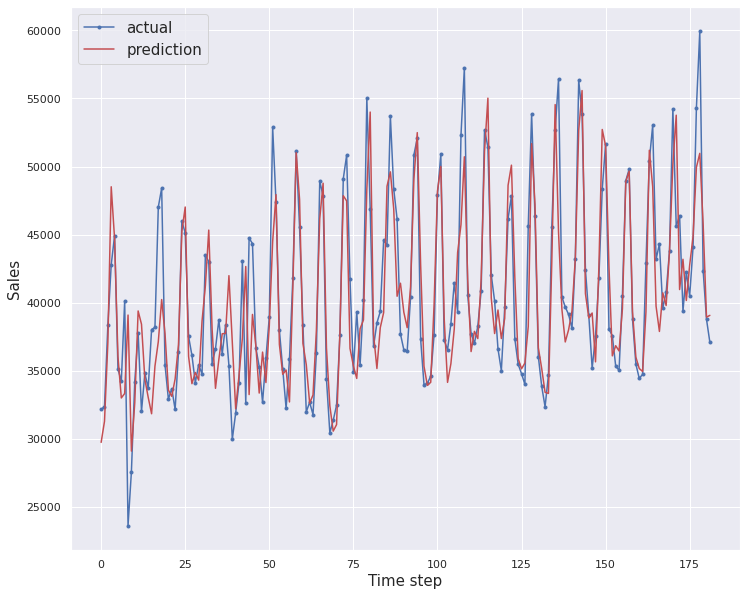

Time Taken for current trial is: 00:00:26
****************************************************************************************************


In [110]:
train = (train_X, train_y)
print("Train dataset shape-",train[0].shape)
#raise Exception 
test = (test_X, test_y)
print("Test dataset shape-",test[0].shape)
trial_history = dict()
for i in range(grid.shape[0]):
  print("*"*10,"Trial-%d"%(i+1),"*"*10)
  print("Number of repeats tried-%d"%(grid.loc[i,"repeat"]))
  print("Epochs used in model-%d"%(grid.loc[i,"epoch"]))
  print("Learning rate used in model-%.5f"%(grid.loc[i,"learning_rate"]))
  print("Error metric used in model-%s"%(grid.loc[i,"loss"]))
  start_time = time.time()
  trial_dat = run_model(train, test, n_repeats=grid.loc[i,"repeat"], epochs=grid.loc[i,"epoch"], verbose=0, window=prediction_window, learning_rate=grid.loc[i,"learning_rate"],
                 loss= grid.loc[i,"loss"], model_type="LSTM", n_in=8)
  trial_history["Trial-"+str(i+1)] = trial_dat
  #print(trial_history)
  time_elapsed = time.time() - start_time
  print('Time Taken for current trial is:', time.strftime("%H:%M:%S",time.gmtime(time_elapsed)))
  print("*"*100)

### Window-7

In [112]:
prediction_window = 7
# Scale dataset

# scaler, scaled = scale_data(dat, range=(-1,1))
# scaled_df = pd.DataFrame(scaled)
# scaled_df.set_index(dat.index, inplace=True)
# scaled_df.columns = dat.columns
# scaled_df[["total_sales"]]
#scaled_df_subset = 
# frame as supervised learning
print(dat)
reframed = series_to_supervised(dat[["total_sales"]], 7, n_out=prediction_window)
reframed = pd.merge(dat[["Unemployment_Rate"]], reframed, left_index=True, right_index=True)
print(reframed)
scaler, scaled = scale_data(reframed, range=(-1,1))
reframed = pd.DataFrame(scaled)
#scaled_df.set_index(dat.index, inplace=True)
#scaled_df.columns = dat.columns
print("Shape of reframed dataset-",reframed.shape)
print(reframed.head())

            total_sales  Unemployment_Rate
2011-01-29        32631               9.43
2011-01-30        31749               9.43
2011-01-31        23783               9.43
2011-02-01        25412               9.37
2011-02-02        19146               9.37
...                 ...                ...
2016-05-18        37096               4.70
2016-05-19        36963               4.70
2016-05-20        42552               4.70
2016-05-21        51518               4.70
2016-05-22        54338               4.70

[1936 rows x 2 columns]
            Unemployment_Rate  var1(t-7)  ...  var1(t+5)  var1(t+6)
2011-02-05               9.37    32631.0  ...    23756.0    26445.0
2011-02-06               9.37    31749.0  ...    26445.0    34833.0
2011-02-07               9.37    23783.0  ...    34833.0    36380.0
2011-02-08               9.37    25412.0  ...    36380.0    21804.0
2011-02-09               9.37    19146.0  ...    21804.0    24070.0
...                       ...        ...  ...      

In [113]:
total_no_of_weeks = reframed.shape[0]//7
test_data_time_period = 26
train_data_time_period = total_no_of_weeks - test_data_time_period
train_data_time_period


248

In [114]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1736
182
(1736, 1, 8) (1736, 7) (182, 1, 8) (182, 7)


Train dataset shape- (1736, 1, 8)
Test dataset shape- (182, 1, 8)
********** Trial-1 **********
Number of repeats tried-1
Epochs used in model-100
Learning rate used in model-0.00300
Error metric used in model-mse
Compiling LSTM Model Architecture
Iteration-1
Test RMSE: 4082.009
MAPE: 7.587
Model-Loss = 0.024768
Model-Validation-Loss = 0.039244
Average MAPE for test data over 1 repetitions is 7.5872
Average MAE for test data over 1 repetitions is 3038.0565
Average RMSE for test data over 1 repetitions is 4082.0092


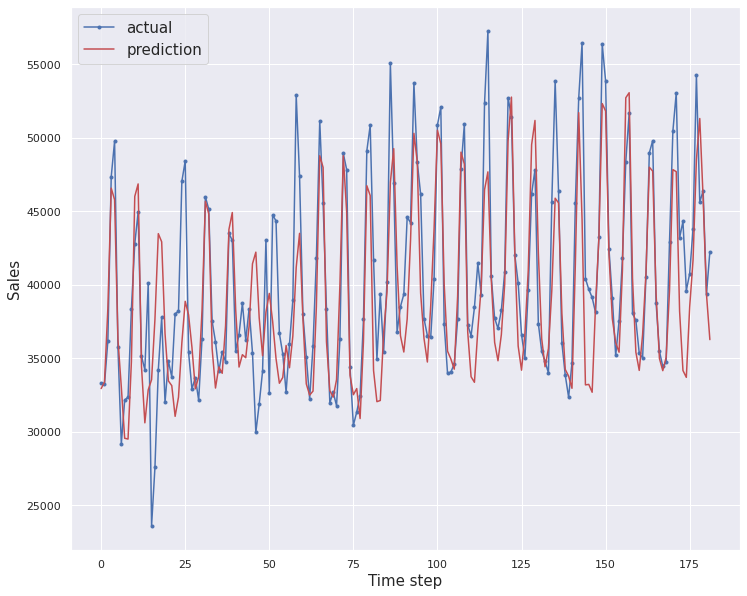

Time Taken for current trial is: 00:00:24
****************************************************************************************************


In [115]:
train = (train_X, train_y)
print("Train dataset shape-",train[0].shape)
#raise Exception 
test = (test_X, test_y)
print("Test dataset shape-",test[0].shape)
trial_history = dict()
for i in range(grid.shape[0]):
  print("*"*10,"Trial-%d"%(i+1),"*"*10)
  print("Number of repeats tried-%d"%(grid.loc[i,"repeat"]))
  print("Epochs used in model-%d"%(grid.loc[i,"epoch"]))
  print("Learning rate used in model-%.5f"%(grid.loc[i,"learning_rate"]))
  print("Error metric used in model-%s"%(grid.loc[i,"loss"]))
  start_time = time.time()
  trial_dat = run_model(train, test, n_repeats=grid.loc[i,"repeat"], epochs=grid.loc[i,"epoch"], verbose=0, window=prediction_window, learning_rate=grid.loc[i,"learning_rate"],
                 loss= grid.loc[i,"loss"], model_type="LSTM", n_in=8)
  trial_history["Trial-"+str(i+1)] = trial_dat
  #print(trial_history)
  time_elapsed = time.time() - start_time
  print('Time Taken for current trial is:', time.strftime("%H:%M:%S",time.gmtime(time_elapsed)))
  print("*"*100)

## CNN

### Window -1

In [116]:
prediction_window = 1
reframed = series_to_supervised(dat[["total_sales"]], 7, n_out=prediction_window)
reframed = pd.merge(dat[["Unemployment_Rate"]], reframed, left_index=True, right_index=True)
print(reframed)
scaler, scaled = scale_data(reframed, range=(-1,1))
reframed = pd.DataFrame(scaled)
#scaled_df.set_index(dat.index, inplace=True)
#scaled_df.columns = dat.columns
print("Shape of reframed dataset-",reframed.shape)
print(reframed.head())

            Unemployment_Rate  var1(t-7)  ...  var1(t-1)  var1(t)
2011-02-05               9.37    32631.0  ...    28010.0    37932
2011-02-06               9.37    31749.0  ...    37932.0    32736
2011-02-07               9.37    23783.0  ...    32736.0    25572
2011-02-08               9.37    25412.0  ...    25572.0    23071
2011-02-09               9.37    19146.0  ...    23071.0    23658
...                       ...        ...  ...        ...      ...
2016-05-18               4.70    42248.0  ...    38777.0    37096
2016-05-19               4.70    40503.0  ...    37096.0    36963
2016-05-20               4.70    44073.0  ...    36963.0    42552
2016-05-21               4.70    54308.0  ...    42552.0    51518
2016-05-22               4.70    59921.0  ...    51518.0    54338

[1929 rows x 9 columns]
Shape of scaled dataset- (1929, 9)
Shape of reframed dataset- (1929, 9)
     0         1         2         3  ...         5         6         7         8
0  1.0 -0.299771 -0.341779 -0

In [117]:
total_no_of_weeks = reframed.shape[0]//7
test_data_time_period = 26
train_data_time_period = total_no_of_weeks - test_data_time_period
train_data_time_period


249

In [118]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1743
182
(1743, 8) (1743, 1) (182, 8) (182, 1)


In [122]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1743, 8, 1)
Validation set shape (182, 8, 1)


Train dataset shape- (1743, 8, 1)
Test dataset shape- (182, 8, 1)
********** Trial-1 **********
Number of repeats tried-1
Epochs used in model-100
Learning rate used in model-0.00300
Error metric used in model-mse
Compiling CNN Model Architecture
Iteration-1
Test RMSE: 5318.385
MAPE: 10.176
Model-Loss = 0.017541
Model-Validation-Loss = 0.064163
Average MAPE for test data over 1 repetitions is 10.1763
Average MAE for test data over 1 repetitions is 3901.0401
Average RMSE for test data over 1 repetitions is 5318.3850


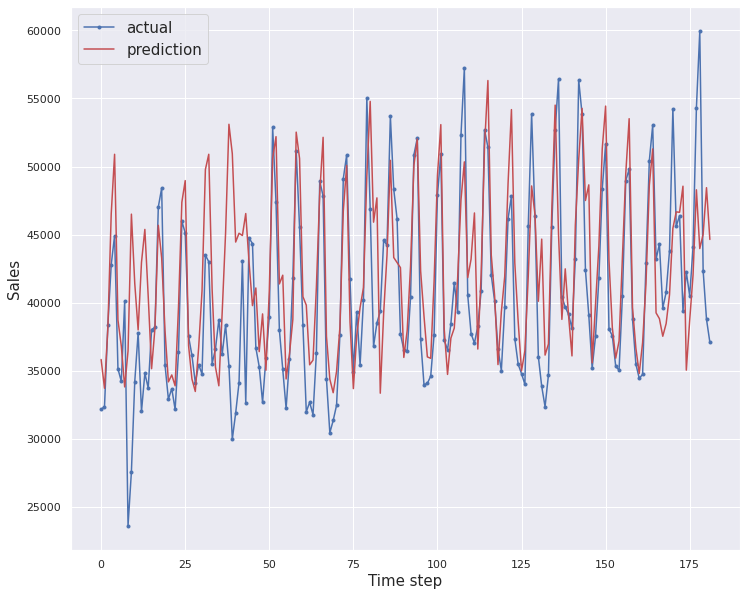

Time Taken for current trial is: 00:00:19
****************************************************************************************************


In [123]:
train = (X_train_series, train_y)
print("Train dataset shape-",train[0].shape)
#raise Exception 
test = (X_valid_series, test_y)
print("Test dataset shape-",test[0].shape)
trial_history = dict()
for i in range(grid.shape[0]):
  print("*"*10,"Trial-%d"%(i+1),"*"*10)
  print("Number of repeats tried-%d"%(grid.loc[i,"repeat"]))
  print("Epochs used in model-%d"%(grid.loc[i,"epoch"]))
  print("Learning rate used in model-%.5f"%(grid.loc[i,"learning_rate"]))
  print("Error metric used in model-%s"%(grid.loc[i,"loss"]))
  start_time = time.time()
  trial_dat = run_model(train, test, n_repeats=grid.loc[i,"repeat"], epochs=grid.loc[i,"epoch"], verbose=0, window=prediction_window, learning_rate=grid.loc[i,"learning_rate"],
                 loss= grid.loc[i,"loss"], model_type="CNN", n_in=8)
  trial_history["Trial-"+str(i+1)] = trial_dat
  #print(trial_history)
  time_elapsed = time.time() - start_time
  print('Time Taken for current trial is:', time.strftime("%H:%M:%S",time.gmtime(time_elapsed)))
  print("*"*100)

### Window -7

In [124]:
prediction_window = 7
reframed = series_to_supervised(dat[["total_sales"]], 7, n_out=prediction_window)
reframed = pd.merge(dat[["Unemployment_Rate"]], reframed, left_index=True, right_index=True)
print(reframed)
scaler, scaled = scale_data(reframed, range=(-1,1))
reframed = pd.DataFrame(scaled)
#scaled_df.set_index(dat.index, inplace=True)
#scaled_df.columns = dat.columns
print("Shape of reframed dataset-",reframed.shape)
#print(reframed.head())

            Unemployment_Rate  var1(t-7)  ...  var1(t+5)  var1(t+6)
2011-02-05               9.37    32631.0  ...    23756.0    26445.0
2011-02-06               9.37    31749.0  ...    26445.0    34833.0
2011-02-07               9.37    23783.0  ...    34833.0    36380.0
2011-02-08               9.37    25412.0  ...    36380.0    21804.0
2011-02-09               9.37    19146.0  ...    21804.0    24070.0
...                       ...        ...  ...        ...        ...
2016-05-12               4.70    40763.0  ...    38777.0    37096.0
2016-05-13               4.70    43805.0  ...    37096.0    36963.0
2016-05-14               4.70    54239.0  ...    36963.0    42552.0
2016-05-15               4.70    45609.0  ...    42552.0    51518.0
2016-05-16               4.70    46400.0  ...    51518.0    54338.0

[1923 rows x 15 columns]
Shape of scaled dataset- (1923, 15)
Shape of reframed dataset- (1923, 15)


In [125]:
total_no_of_weeks = reframed.shape[0]//7
test_data_time_period = 26
train_data_time_period = total_no_of_weeks - test_data_time_period
train_data_time_period


248

In [126]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1736
182
(1736, 8) (1736, 7) (182, 8) (182, 7)


In [127]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1736, 8, 1)
Validation set shape (182, 8, 1)


Train dataset shape- (1736, 8, 1)
Test dataset shape- (182, 8, 1)
********** Trial-1 **********
Number of repeats tried-1
Epochs used in model-100
Learning rate used in model-0.00300
Error metric used in model-mse
Compiling CNN Model Architecture
Iteration-1
Test RMSE: 4201.848
MAPE: 8.614
Model-Loss = 0.022719
Model-Validation-Loss = 0.050348
Average MAPE for test data over 1 repetitions is 8.6137
Average MAE for test data over 1 repetitions is 3290.8349
Average RMSE for test data over 1 repetitions is 4201.8485


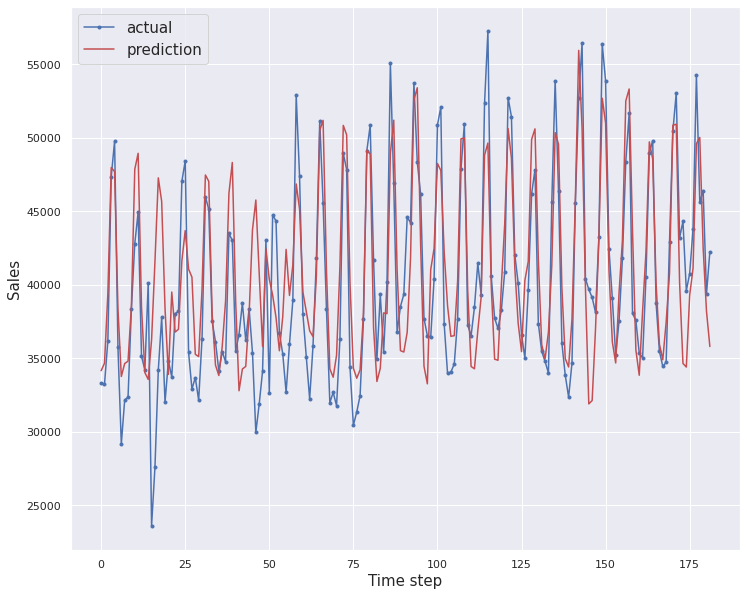

Time Taken for current trial is: 00:00:12
****************************************************************************************************


In [128]:
train = (X_train_series, train_y)
print("Train dataset shape-",train[0].shape)
#raise Exception 
test = (X_valid_series, test_y)
print("Test dataset shape-",test[0].shape)
trial_history = dict()
for i in range(grid.shape[0]):
  print("*"*10,"Trial-%d"%(i+1),"*"*10)
  print("Number of repeats tried-%d"%(grid.loc[i,"repeat"]))
  print("Epochs used in model-%d"%(grid.loc[i,"epoch"]))
  print("Learning rate used in model-%.5f"%(grid.loc[i,"learning_rate"]))
  print("Error metric used in model-%s"%(grid.loc[i,"loss"]))
  start_time = time.time()
  trial_dat = run_model(train, test, n_repeats=grid.loc[i,"repeat"], epochs=grid.loc[i,"epoch"], verbose=0, window=prediction_window, learning_rate=grid.loc[i,"learning_rate"],
                 loss= grid.loc[i,"loss"], model_type="CNN", n_in=8)
  trial_history["Trial-"+str(i+1)] = trial_dat
  #print(trial_history)
  time_elapsed = time.time() - start_time
  print('Time Taken for current trial is:', time.strftime("%H:%M:%S",time.gmtime(time_elapsed)))
  print("*"*100)

## CNN + LSTM

### Window-1

In [131]:
prediction_window = 1#
reframed = series_to_supervised(dat[["total_sales"]], 7, n_out=prediction_window)
reframed = pd.merge(dat[["Unemployment_Rate"]], reframed, left_index=True, right_index=True)
#print(reframed)
scaler, scaled = scale_data(reframed, range=(-1,1))
reframed = pd.DataFrame(scaled)
#scaled_df.set_index(dat.index, inplace=True)
#scaled_df.columns = dat.columns
print("Shape of reframed dataset-",reframed.shape)
#print(reframed.head())

Shape of scaled dataset- (1929, 9)
Shape of reframed dataset- (1929, 9)


In [132]:
total_no_of_weeks = reframed.shape[0]//7
test_data_time_period = 26
train_data_time_period = total_no_of_weeks - test_data_time_period
train_data_time_period


249

In [133]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1743
182
(1743, 8) (1743, 1) (182, 8) (182, 1)


In [134]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1743, 8, 1)
Validation set shape (182, 8, 1)


In [135]:
subsequences = 1
timesteps = train_X.shape[1]//subsequences
print(timesteps)
X_train_series_sub = train_X.reshape((train_X.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = test_X.reshape((test_X.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

8
Train set shape (1743, 1, 8, 1)
Validation set shape (182, 1, 8, 1)


Train dataset shape- (1743, 1, 8, 1)
Test dataset shape- (182, 1, 8, 1)
********** Trial-1 **********
Number of repeats tried-1
Epochs used in model-100
Learning rate used in model-0.00300
Error metric used in model-mse
Compiling CNN-LSTM Model Architecture
Iteration-1
Test RMSE: 5452.938
MAPE: 10.115
Model-Loss = 0.014370
Model-Validation-Loss = 0.067451
Average MAPE for test data over 1 repetitions is 10.1154
Average MAE for test data over 1 repetitions is 3936.4097
Average RMSE for test data over 1 repetitions is 5452.9382


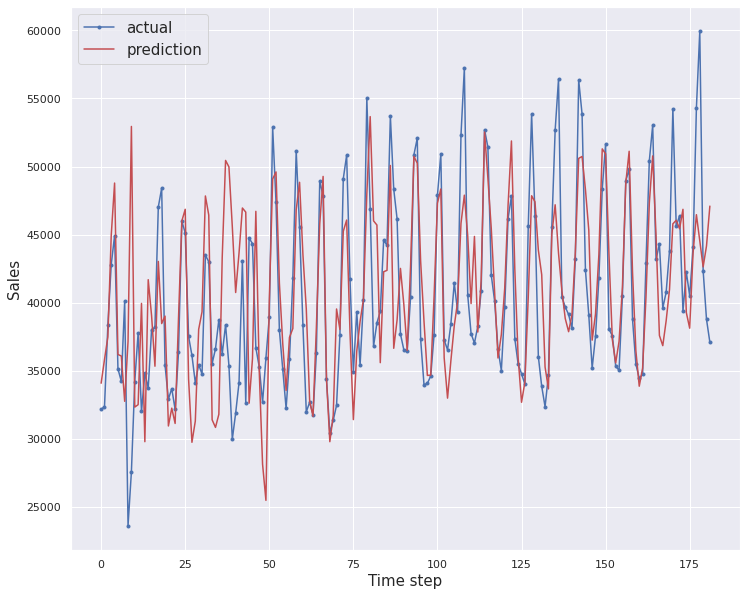

Time Taken for current trial is: 00:00:35
****************************************************************************************************


In [136]:
train = (X_train_series_sub, train_y)
print("Train dataset shape-",train[0].shape)
#raise Exception 
test = (X_valid_series_sub, test_y)
print("Test dataset shape-",test[0].shape)
trial_history = dict()
for i in range(grid.shape[0]):
  print("*"*10,"Trial-%d"%(i+1),"*"*10)
  print("Number of repeats tried-%d"%(grid.loc[i,"repeat"]))
  print("Epochs used in model-%d"%(grid.loc[i,"epoch"]))
  print("Learning rate used in model-%.5f"%(grid.loc[i,"learning_rate"]))
  print("Error metric used in model-%s"%(grid.loc[i,"loss"]))
  start_time = time.time()
  trial_dat = run_model(train, test, n_repeats=grid.loc[i,"repeat"], epochs=grid.loc[i,"epoch"], verbose=0, window=prediction_window, learning_rate=grid.loc[i,"learning_rate"],
                 loss= grid.loc[i,"loss"], model_type="CNN-LSTM", n_in=8)
  trial_history["Trial-"+str(i+1)] = trial_dat
  #print(trial_history)
  time_elapsed = time.time() - start_time
  print('Time Taken for current trial is:', time.strftime("%H:%M:%S",time.gmtime(time_elapsed)))
  print("*"*100)

### Window-7

In [137]:
prediction_window = 7#
reframed = series_to_supervised(dat[["total_sales"]], 7, n_out=prediction_window)
reframed = pd.merge(dat[["Unemployment_Rate"]], reframed, left_index=True, right_index=True)
#print(reframed)
scaler, scaled = scale_data(reframed, range=(-1,1))
reframed = pd.DataFrame(scaled)
#scaled_df.set_index(dat.index, inplace=True)
#scaled_df.columns = dat.columns
print("Shape of reframed dataset-",reframed.shape)
#print(reframed.head())

Shape of scaled dataset- (1923, 15)
Shape of reframed dataset- (1923, 15)


In [138]:
total_no_of_weeks = reframed.shape[0]//7
test_data_time_period = 26
train_data_time_period = total_no_of_weeks - test_data_time_period
train_data_time_period


248

In [139]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1736
182
(1736, 8) (1736, 7) (182, 8) (182, 7)


In [140]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1736, 8, 1)
Validation set shape (182, 8, 1)


In [141]:
subsequences = 1
timesteps = train_X.shape[1]//subsequences
print(timesteps)
X_train_series_sub = train_X.reshape((train_X.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = test_X.reshape((test_X.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

8
Train set shape (1736, 1, 8, 1)
Validation set shape (182, 1, 8, 1)


Train dataset shape- (1736, 1, 8, 1)
Test dataset shape- (182, 1, 8, 1)
********** Trial-1 **********
Number of repeats tried-1
Epochs used in model-100
Learning rate used in model-0.00300
Error metric used in model-mse
Compiling CNN-LSTM Model Architecture
Iteration-1
Test RMSE: 4361.431
MAPE: 8.807
Model-Loss = 0.020209
Model-Validation-Loss = 0.053684
Average MAPE for test data over 1 repetitions is 8.8075
Average MAE for test data over 1 repetitions is 3402.1002
Average RMSE for test data over 1 repetitions is 4361.4314


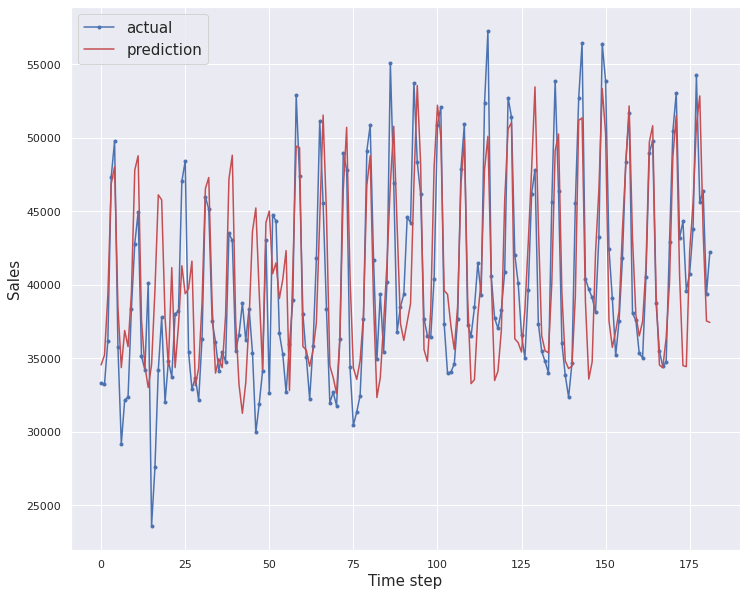

Time Taken for current trial is: 00:00:44
****************************************************************************************************


In [142]:
train = (X_train_series_sub, train_y)
print("Train dataset shape-",train[0].shape)
#raise Exception 
test = (X_valid_series_sub, test_y)
print("Test dataset shape-",test[0].shape)
trial_history = dict()
for i in range(grid.shape[0]):
  print("*"*10,"Trial-%d"%(i+1),"*"*10)
  print("Number of repeats tried-%d"%(grid.loc[i,"repeat"]))
  print("Epochs used in model-%d"%(grid.loc[i,"epoch"]))
  print("Learning rate used in model-%.5f"%(grid.loc[i,"learning_rate"]))
  print("Error metric used in model-%s"%(grid.loc[i,"loss"]))
  start_time = time.time()
  trial_dat = run_model(train, test, n_repeats=grid.loc[i,"repeat"], epochs=grid.loc[i,"epoch"], verbose=0, window=prediction_window, learning_rate=grid.loc[i,"learning_rate"],
                 loss= grid.loc[i,"loss"], model_type="CNN-LSTM", n_in=8)
  trial_history["Trial-"+str(i+1)] = trial_dat
  #print(trial_history)
  time_elapsed = time.time() - start_time
  print('Time Taken for current trial is:', time.strftime("%H:%M:%S",time.gmtime(time_elapsed)))
  print("*"*100)

## TCN

### Window-1

In [183]:
prediction_window = 1#
reframed = series_to_supervised(dat[["total_sales"]], 7, n_out=prediction_window)
reframed = pd.merge(dat[["Unemployment_Rate"]], reframed, left_index=True, right_index=True)
#print(reframed)
scaler, scaled = scale_data(reframed, range=(-1,1))
reframed = pd.DataFrame(scaled)
#scaled_df.set_index(dat.index, inplace=True)
#scaled_df.columns = dat.columns
print("Shape of reframed dataset-",reframed.shape)
#print(reframed.head())

Shape of scaled dataset- (1929, 9)
Shape of reframed dataset- (1929, 9)


In [184]:
total_no_of_weeks = reframed.shape[0]//7
test_data_time_period = 26
train_data_time_period = total_no_of_weeks - test_data_time_period
train_data_time_period


249

In [185]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1743
182
(1743, 8) (1743, 1) (182, 8) (182, 1)


In [180]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1743, 8, 1)
Validation set shape (182, 8, 1)


Train dataset shape- (1743, 8, 1)
Test dataset shape- (182, 8, 1)
********** Trial-1 **********
Number of repeats tried-1
Epochs used in model-100
Learning rate used in model-0.00300
Error metric used in model-mse
Compiling TCN Model Architecture
Receptive field size = 29
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_1 (TCN)                  (None, 128)               247168    
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 129       
Total params: 247,297
Trainable params: 247,297
Non-trainable params: 0
_________________________________________________________________
Iteration-1
Test RMSE: 5052.696
MAPE: 9.105
Model-Loss = 0.008502
Model-Validation-Loss = 0.057913
Average MAPE for test data over 1 repetitions is 9.1052
Average MAE for test data over 1 repetitions is 3732.5184
Average RMSE for test d

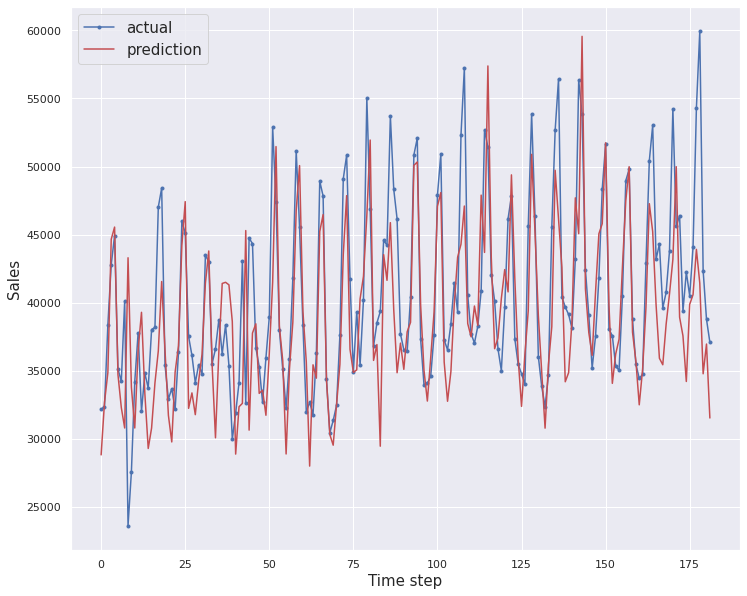

Time Taken for current trial is: 00:01:50
****************************************************************************************************


In [187]:
train = (X_train_series, train_y)
print("Train dataset shape-",train[0].shape)
#raise Exception 
test = (X_valid_series, test_y)
print("Test dataset shape-",test[0].shape)
trial_history = dict()
for i in range(grid.shape[0]):
  print("*"*10,"Trial-%d"%(i+1),"*"*10)
  print("Number of repeats tried-%d"%(grid.loc[i,"repeat"]))
  print("Epochs used in model-%d"%(grid.loc[i,"epoch"]))
  print("Learning rate used in model-%.5f"%(grid.loc[i,"learning_rate"]))
  print("Error metric used in model-%s"%(grid.loc[i,"loss"]))
  start_time = time.time()
  trial_dat = run_model(train, test, n_repeats=grid.loc[i,"repeat"], epochs=grid.loc[i,"epoch"], verbose=0, window=prediction_window, learning_rate=grid.loc[i,"learning_rate"],
                 loss= grid.loc[i,"loss"], model_type="TCN", n_in=8)
  trial_history["Trial-"+str(i+1)] = trial_dat
  #print(trial_history)
  time_elapsed = time.time() - start_time
  print('Time Taken for current trial is:', time.strftime("%H:%M:%S",time.gmtime(time_elapsed)))
  print("*"*100)

### Window-7

In [34]:
prediction_window = 7#
reframed = series_to_supervised(dat[["total_sales"]], 7, n_out=prediction_window)
reframed = pd.merge(dat[["Unemployment_Rate"]], reframed, left_index=True, right_index=True)
#print(reframed)
scaler, scaled = scale_data(reframed, range=(-1,1))
reframed = pd.DataFrame(scaled)
#scaled_df.set_index(dat.index, inplace=True)
#scaled_df.columns = dat.columns
print("Shape of reframed dataset-",reframed.shape)
#print(reframed.head())

Shape of scaled dataset- (1923, 15)
Shape of reframed dataset- (1923, 15)


In [35]:
total_no_of_weeks = reframed.shape[0]//7
test_data_time_period = 26
train_data_time_period = total_no_of_weeks - test_data_time_period
train_data_time_period


248

In [36]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1736
182
(1736, 8) (1736, 7) (182, 8) (182, 7)


In [37]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1736, 8, 1)
Validation set shape (182, 8, 1)


Train dataset shape- (1736, 8, 1)
Test dataset shape- (182, 8, 1)
********** Trial-1 **********
Number of repeats tried-1
Epochs used in model-100
Learning rate used in model-0.00300
Error metric used in model-mse
Compiling TCN Model Architecture
Receptive field size = 29
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn (TCN)                    (None, 128)               247168    
_________________________________________________________________
dense (Dense)                (None, 7)                 903       
Total params: 248,071
Trainable params: 248,071
Non-trainable params: 0
_________________________________________________________________
Iteration-1
Test RMSE: 5077.117
MAPE: 9.896
Model-Loss = 0.012204
Model-Validation-Loss = 0.062287
Average MAPE for test data over 1 repetitions is 9.8958
Average MAE for test data over 1 repetitions is 3863.7550
Average RMSE for test data

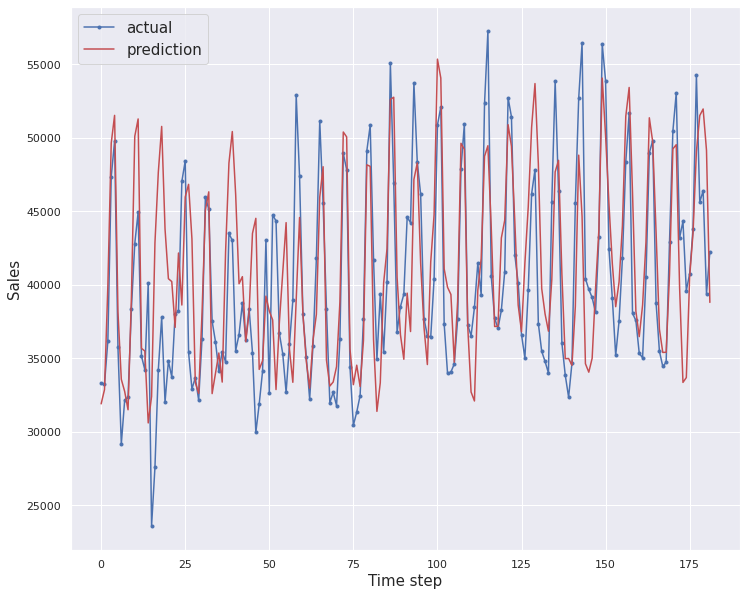

Time Taken for current trial is: 00:01:48
****************************************************************************************************


In [38]:
train = (X_train_series, train_y)
print("Train dataset shape-",train[0].shape)
#raise Exception 
test = (X_valid_series, test_y)
print("Test dataset shape-",test[0].shape)
trial_history = dict()
for i in range(grid.shape[0]):
  print("*"*10,"Trial-%d"%(i+1),"*"*10)
  print("Number of repeats tried-%d"%(grid.loc[i,"repeat"]))
  print("Epochs used in model-%d"%(grid.loc[i,"epoch"]))
  print("Learning rate used in model-%.5f"%(grid.loc[i,"learning_rate"]))
  print("Error metric used in model-%s"%(grid.loc[i,"loss"]))
  start_time = time.time()
  trial_dat = run_model(train, test, n_repeats=grid.loc[i,"repeat"], epochs=grid.loc[i,"epoch"], verbose=0, window=prediction_window, learning_rate=grid.loc[i,"learning_rate"],
                 loss= grid.loc[i,"loss"], model_type="TCN", n_in=8)
  trial_history["Trial-"+str(i+1)] = trial_dat
  #print(trial_history)
  time_elapsed = time.time() - start_time
  print('Time Taken for current trial is:', time.strftime("%H:%M:%S",time.gmtime(time_elapsed)))
  print("*"*100)

## MACNN

### Window-1

In [64]:
prediction_window = 1#
reframed = series_to_supervised(dat[["total_sales"]], 28, n_out=prediction_window)
reframed = pd.merge(dat[["Unemployment_Rate"]], reframed, left_index=True, right_index=True)
#print(reframed)
scaler, scaled = scale_data(reframed, range=(-1,1))
reframed = pd.DataFrame(scaled)
#scaled_df.set_index(dat.index, inplace=True)
#scaled_df.columns = dat.columns
print("Shape of reframed dataset-",reframed.shape)
#print(reframed.head())

Shape of scaled dataset- (1908, 30)
Shape of reframed dataset- (1908, 30)


In [65]:
total_no_of_weeks = reframed.shape[0]//7
test_data_time_period = 26
train_data_time_period = total_no_of_weeks - test_data_time_period
train_data_time_period


246

In [66]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1722
182
(1722, 29) (1722, 1) (182, 29) (182, 1)


In [67]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1722, 29, 1)
Validation set shape (182, 29, 1)


#### WOReg

Train dataset shape- (1722, 29, 1)
Test dataset shape- (182, 29, 1)
********** Trial-1 **********
Number of repeats tried-1
Epochs used in model-100
Learning rate used in model-0.00300
Error metric used in model-mse
Compiling MACNN model Architecture(without regularization)
Model: "MACNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
series (InputLayer)             [(None, 29, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 29, 64)       192         series[0][0]                     
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 29, 64)       512         series[0][0]                     
_________________

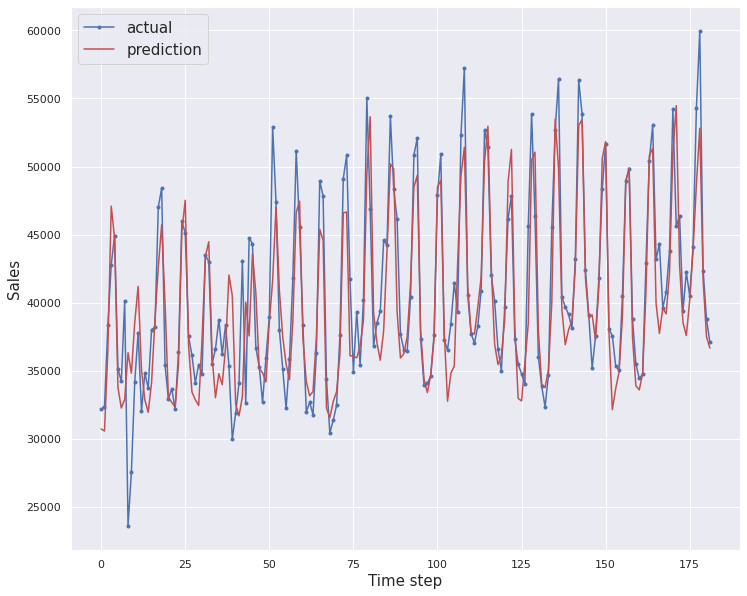

Time Taken for current trial is: 00:00:54
****************************************************************************************************


In [56]:
train = (X_train_series, train_y)
print("Train dataset shape-",train[0].shape)
#raise Exception 
test = (X_valid_series, test_y)
print("Test dataset shape-",test[0].shape)
trial_history = dict()
for i in range(grid.shape[0]):
  print("*"*10,"Trial-%d"%(i+1),"*"*10)
  print("Number of repeats tried-%d"%(grid.loc[i,"repeat"]))
  print("Epochs used in model-%d"%(grid.loc[i,"epoch"]))
  print("Learning rate used in model-%.5f"%(grid.loc[i,"learning_rate"]))
  print("Error metric used in model-%s"%(grid.loc[i,"loss"]))
  start_time = time.time()
  trial_dat = run_model(train, test, n_repeats=grid.loc[i,"repeat"], epochs=grid.loc[i,"epoch"], verbose=0, window=prediction_window, learning_rate=grid.loc[i,"learning_rate"],
                 loss= grid.loc[i,"loss"], model_type="MACNN", n_in=29, l2_regularizer=False)
  trial_history["Trial-"+str(i+1)] = trial_dat
  #print(trial_history)
  time_elapsed = time.time() - start_time
  print('Time Taken for current trial is:', time.strftime("%H:%M:%S",time.gmtime(time_elapsed)))
  print("*"*100)

#### With Reg

Train dataset shape- (1722, 29, 1)
Test dataset shape- (182, 29, 1)
********** Trial-1 **********
Number of repeats tried-1
Epochs used in model-100
Learning rate used in model-0.00300
Error metric used in model-mse
Compiling MACNN model Architecture(with regularization)
Model: "MACNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
series (InputLayer)             [(None, 29, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_24 (Conv1D)              (None, 29, 64)       192         series[0][0]                     
__________________________________________________________________________________________________
conv1d_25 (Conv1D)              (None, 29, 64)       512         series[0][0]                     
____________________

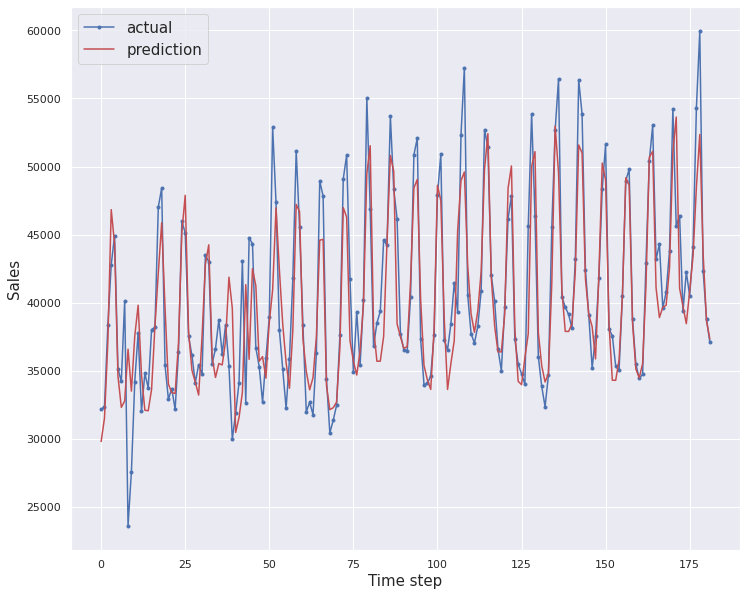

Time Taken for current trial is: 00:00:54
****************************************************************************************************


In [68]:
train = (X_train_series, train_y)
print("Train dataset shape-",train[0].shape)
#raise Exception 
test = (X_valid_series, test_y)
print("Test dataset shape-",test[0].shape)
trial_history = dict()
for i in range(grid.shape[0]):
  print("*"*10,"Trial-%d"%(i+1),"*"*10)
  print("Number of repeats tried-%d"%(grid.loc[i,"repeat"]))
  print("Epochs used in model-%d"%(grid.loc[i,"epoch"]))
  print("Learning rate used in model-%.5f"%(grid.loc[i,"learning_rate"]))
  print("Error metric used in model-%s"%(grid.loc[i,"loss"]))
  start_time = time.time()
  trial_dat = run_model(train, test, n_repeats=grid.loc[i,"repeat"], epochs=grid.loc[i,"epoch"], verbose=0, window=prediction_window, learning_rate=grid.loc[i,"learning_rate"],
                 loss= grid.loc[i,"loss"], model_type="MACNN", n_in=29, l2_regularizer=True)
  trial_history["Trial-"+str(i+1)] = trial_dat
  #print(trial_history)
  time_elapsed = time.time() - start_time
  print('Time Taken for current trial is:', time.strftime("%H:%M:%S",time.gmtime(time_elapsed)))
  print("*"*100)

### Window-7

In [57]:
prediction_window = 7#
reframed = series_to_supervised(dat[["total_sales"]], 28, n_out=prediction_window)
reframed = pd.merge(dat[["Unemployment_Rate"]], reframed, left_index=True, right_index=True)
#print(reframed)
scaler, scaled = scale_data(reframed, range=(-1,1))
reframed = pd.DataFrame(scaled)
#scaled_df.set_index(dat.index, inplace=True)
#scaled_df.columns = dat.columns
print("Shape of reframed dataset-",reframed.shape)
#print(reframed.head())

Shape of scaled dataset- (1902, 36)
Shape of reframed dataset- (1902, 36)


In [58]:
total_no_of_weeks = reframed.shape[0]//7
test_data_time_period = 26
train_data_time_period = total_no_of_weeks - test_data_time_period
train_data_time_period


245

In [59]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1715
182
(1715, 29) (1715, 7) (182, 29) (182, 7)


In [61]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1715, 29, 1)
Validation set shape (182, 29, 1)


#### WO Reg

Train dataset shape- (1715, 29, 1)
Test dataset shape- (182, 29, 1)
********** Trial-1 **********
Number of repeats tried-1
Epochs used in model-100
Learning rate used in model-0.00300
Error metric used in model-mse
Compiling MACNN model Architecture(without regularization)
Model: "MACNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
series (InputLayer)             [(None, 29, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 29, 64)       192         series[0][0]                     
__________________________________________________________________________________________________
conv1d_17 (Conv1D)              (None, 29, 64)       512         series[0][0]                     
_________________

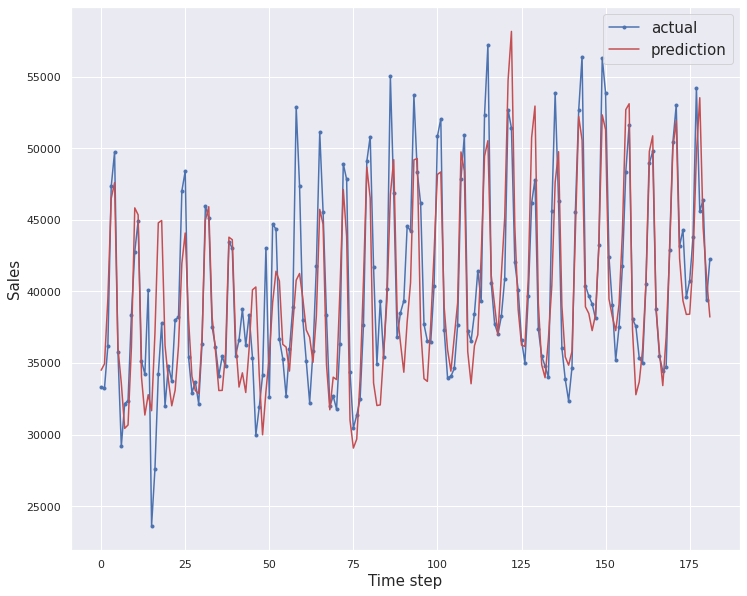

Time Taken for current trial is: 00:00:52
****************************************************************************************************


In [62]:
train = (X_train_series, train_y)
print("Train dataset shape-",train[0].shape)
#raise Exception 
test = (X_valid_series, test_y)
print("Test dataset shape-",test[0].shape)
trial_history = dict()
for i in range(grid.shape[0]):
  print("*"*10,"Trial-%d"%(i+1),"*"*10)
  print("Number of repeats tried-%d"%(grid.loc[i,"repeat"]))
  print("Epochs used in model-%d"%(grid.loc[i,"epoch"]))
  print("Learning rate used in model-%.5f"%(grid.loc[i,"learning_rate"]))
  print("Error metric used in model-%s"%(grid.loc[i,"loss"]))
  start_time = time.time()
  trial_dat = run_model(train, test, n_repeats=grid.loc[i,"repeat"], epochs=grid.loc[i,"epoch"], verbose=0, window=prediction_window, learning_rate=grid.loc[i,"learning_rate"],
                 loss= grid.loc[i,"loss"], model_type="MACNN", n_in=29, l2_regularizer=False)
  trial_history["Trial-"+str(i+1)] = trial_dat
  #print(trial_history)
  time_elapsed = time.time() - start_time
  print('Time Taken for current trial is:', time.strftime("%H:%M:%S",time.gmtime(time_elapsed)))
  print("*"*100)

#### With Reg

Train dataset shape- (1715, 29, 1)
Test dataset shape- (182, 29, 1)
********** Trial-1 **********
Number of repeats tried-1
Epochs used in model-100
Learning rate used in model-0.00300
Error metric used in model-mse
Compiling MACNN model Architecture(with regularization)
Model: "MACNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
series (InputLayer)             [(None, 29, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_20 (Conv1D)              (None, 29, 64)       192         series[0][0]                     
__________________________________________________________________________________________________
conv1d_21 (Conv1D)              (None, 29, 64)       512         series[0][0]                     
____________________

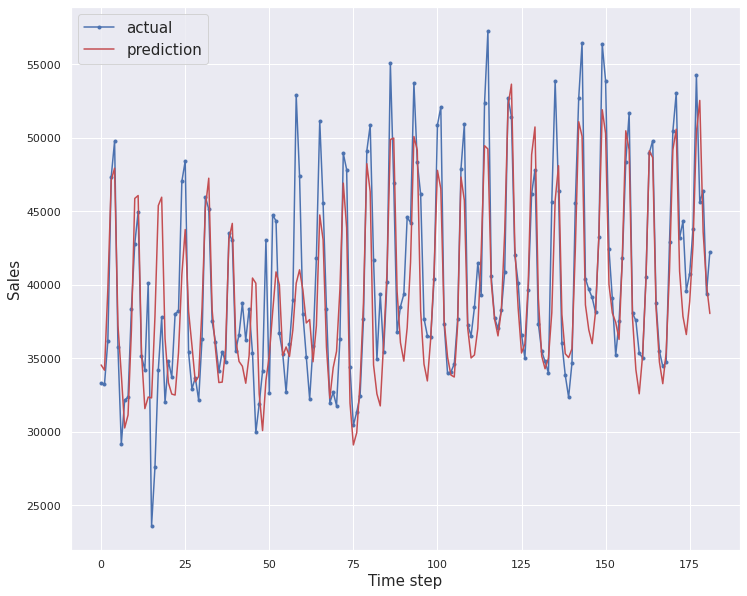

Time Taken for current trial is: 00:01:24
****************************************************************************************************


In [63]:
train = (X_train_series, train_y)
print("Train dataset shape-",train[0].shape)
#raise Exception 
test = (X_valid_series, test_y)
print("Test dataset shape-",test[0].shape)
trial_history = dict()
for i in range(grid.shape[0]):
  print("*"*10,"Trial-%d"%(i+1),"*"*10)
  print("Number of repeats tried-%d"%(grid.loc[i,"repeat"]))
  print("Epochs used in model-%d"%(grid.loc[i,"epoch"]))
  print("Learning rate used in model-%.5f"%(grid.loc[i,"learning_rate"]))
  print("Error metric used in model-%s"%(grid.loc[i,"loss"]))
  start_time = time.time()
  trial_dat = run_model(train, test, n_repeats=grid.loc[i,"repeat"], epochs=grid.loc[i,"epoch"], verbose=0, window=prediction_window, learning_rate=grid.loc[i,"learning_rate"],
                 loss= grid.loc[i,"loss"], model_type="MACNN", n_in=29, l2_regularizer=True)
  trial_history["Trial-"+str(i+1)] = trial_dat
  #print(trial_history)
  time_elapsed = time.time() - start_time
  print('Time Taken for current trial is:', time.strftime("%H:%M:%S",time.gmtime(time_elapsed)))
  print("*"*100)